Vediamo ora come implementare lo stesso NN utilizzando Pytorch anzichè Micrograd. 

Mentre Micrograd è un engine su valori scalari (Value() gestisce solo scalari), Pytorch gestisce tensors (array multidimensionali). <br>Per questo motivo dovremo definire i valori come Tensors che contengono solo un valore scalare

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [74]:
from graphviz import Digraph

# Helper function che serve per ottenere tutti gli edge e i node presenti nel graph partendo dal nodo di root
def trace(root):
    
    # inizializza i set vuoti
    nodes, edges = set(), set()
    
    # Funzione ricorsiva che, dato un nodo, ne estre i children e li aggiunge ai set di Edge e Node
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    # Chiamata iniziale alla funzione ricorsiva
    build(root)
    return nodes, edges

# Funzione che richiama l'API di Graphviz per disegnare il grafo con i nodi e gli edge che compongono la funzione
#
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    
    # Chiamo Helper Function per estrarre gli edge e i node
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
#        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
#        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
test = torch.Tensor([[1,2,3], [4,5,6]])
test

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [5]:
test.shape

torch.Size([2, 3])

In [6]:
test.dtype

torch.float32

Ricreiamo il NN precedente utilizzando Tensor (il cast a double è fatto per lavorare con float64 che è il default di Python, anziche float32 che è il default di pytorch).

Come Value() anche torch.Tensor ha :
- .data
- .grad

In [9]:
import torch

# inputs x1,x2
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

# weights w1,w2
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

# bias of the neuron
b = torch.Tensor([6.8812735870195432]).double()
b.requires_grad = True

n= x1*w1 + x2*w2 +b
o = n.tanh()

print(o.data.item())
o.backward()

print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7070568573976658
-----
x2 0.5000706004069368
w2 0.0
x1 -1.5002118012208105
w1 1.0001412008138737


In [10]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [12]:
o.item()

0.7070568573976658

Copiamo la classe Value() precedentemente creata

In [47]:
class Value:
    
    # Costruttore
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        self._backward = lambda: None   # Funzione che non fa nulla
        self._prev = set(_children) 
        self._op = _op
        self.label = label
        
    # Metodo utilizzato da Python per la visualizzazione dell'oggetto. Consente di impostare un visualizzazione user friendly
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Definisce l'operatore per la somma (+). Quando trova l'operatore +, Python chiama questo metodo
    def __add__(self, other):
        
        # Per gestire la somma di un Value con una costante
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 termini rispetto all'output.
        # Dal momento che la local derivative per una somma è = 1, moltiplico 1 * la derivata del risultato della somma
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    # Metodo x negazione (-Value()). Utilizzato dal metodo successivo x sottrazione
    def __neg__(self):
        return self * -1
    
    # Definisce l'operatore sottrazione
    def __sub__(self, other):
        return self + (-other)
    
    
    # Definisce l'operatore per la prodottp (*). Quando trova l'operatore *, Python chiama questo metodo
    def __mul__(self, other):
        
         # Per gestire la somma di un Value con una costante
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 fattori del prodotto
        # rispetto all'output.
        # Dal momento che la local derivative per un prodotto è = al valore dell'altro fattore,
        # moltiplico l'altro fattore * la derivata del prodotto
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    # Questo metodo viene richiamato da Python in caso di 2 * Value(). Restituirebbe un errore e quindi Python
    # richiama questo metodo per dare l'opportunità di gestire l'errore invertendo l'ordine degli operatori
    def __rmul__(self,other):
        return self * other
    
    def __radd__(self,other):
        return self + other
    
    # Questo metodo viene richiamato dabPython per l'elevazione a potenza (**n). Viene utilizzato per implementare la divisione
    # in quanto a / b corrisponde a a * (1/b) e quindi a * (b**-1)
    #
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data**other, (self,), f'**{other}')
        
        # Sappiamo che la derivata di una potenza è uguale a n x**(n-1)
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    
    # Metodo per la divisione: utilizza la moltiplicazione del valore del dividendo 
    # per il divisone elevato a potenza -1. Quindi utilizza il metodo precedente
    #
    def __truediv__(self,other):
        return self * other**-1
    
    # Metodo per il calcolo della funzione tanh. 
    # E' possibile utilizzare la funzione "composta" invece che le singole operazioni che la compongono in quanto 
    # siamo in grado di calcolarne la derivata
    #
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata della funzione tanh 
        # rispetto all'output.
        # Dal momento che la local derivative per tanh è = (1 - x**2), applicando la chain rule
        # moltiplico questa local derivative* la derivata del prodotto
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    # Calcolo dell'a funzione exp: costituisce una delle operazioni che fanno parte della formula di tanh
    # 
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward= _backward
        
        return out
        
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

I valori ottenuti sono quindi gli stessi che erano stati ottenuti con Micrograd. Micrograd gestisce quindi un piccolo sottoinsieme di quello che viene gestito da Pytorch. Pytorch operando su Tensor è molto più efficiente in quanto può parallelizzare le operazioni 

NEURAL NETWORK sono una specifica classe di espressioni matematiche

Vediamo ora come creare un Neurone utilizzando Pytorch

In [56]:
class Neuron:
    
    # Definisco il costruttore che riceve in input il numero di input al Neuron
    def __init__(self, nin):
        
        # Inizializzo i weigths e bias sulla base del numero di inputs
        #
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    # Metodo richiamato quando l'istanza della classe viene invocata passando il parametro previsto
    # il questo caso il metodo esegue il forward pass
    def __call__(self, x):
        # w * x +b
        # Nel nostro caso dovremo moltiplicare tutti gli elementi di w per tutti gli elementi di x (pairwise)
        # zip riceve 2 iterators e crea un iterator che tratte le tuple date dai 2 iterator
        act = sum(wi*xi for wi, xi in zip(self.w,x)) +self.b
        
        # Per ragioni di efficienza sarebbe preferibile
        # act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out

In [57]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.7914177732666207)

Una volta definito il singolo neuron è possibile definire una MLP composto da più neuron

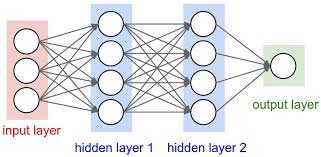

Devo quindi definire una classe Layer.
E 

In [70]:
class Layer:
    
    # Il cotruttore riceve in input il numero di input e il numero di neurons che costituiscono il layer
    #
    def __init__(self, nin, nout):
        
        # Il layer è costituito da una lista di nout Neurons
        #
        self.neurons = [Neuron(nin) for _ in range(nout)]

    # Calcoliamo la lista degli output di ogni singolo neuron che compone il layer
    def __call__(self, x):
        
        outs = [n(x) for n in self.neurons]
        # return outs
        # Per gestire il fatto che può ritornare un singolo numero
        return outs[0] if len(outs) == 1 else outs
    
        

In [71]:
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.3239578250456014),
 Value(data=-0.5362062014135129),
 Value(data=-0.9921735286737385)]

Una volta definito il layer, posso definire l'intero MLP che è a sua volta costituito da una lista di layers

In [72]:
class MLP:
    
    # Riceve il numero di inputs e la lista con le dimensioni dei layers che costutuiscono l'MLP
    def __init__(self, nin, nouts):
        
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
   
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)                                               
        return x
                                                            


Eseguiamo ora un farward pass sul nostro MLP 

In [73]:
x = [2.0, 3.0, .1,0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7994325242051826)

Visualizione il grafico

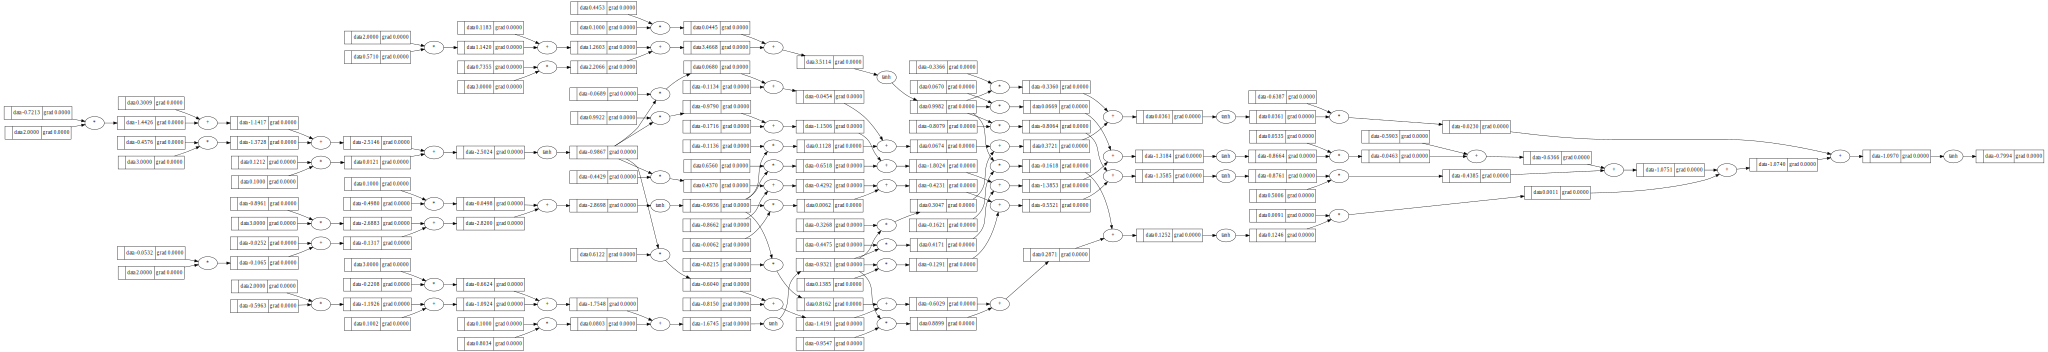

In [76]:
draw_dot(n(x))